In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 12, 16, 15, 58, 13, 426670)

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])


In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
np.random.shuffle(real_data)
data = real_data

In [7]:
# Fraction of overall data
training_fraction = 0.1

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [8]:
sample, label = next(iter(train_dataset.take(1)))

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [10]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[2416 5598    6  493 1933    7    2 5829   13 3509 4344  825   18   15
  2507    9   81 5958   17    3 4345  819 5040   36    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  22    2  718 3329  218    4   47  343    5    3  946 2231   14  213
     4 4926 3550    2 1336  784   18  765   53 3604 3707 5389   90 3331
  4939   80   44    7 1534  176 6639    0    0    0    0

In [12]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'Count Dracula and company participate in a cruise for sea-loving monsters, unaware that their boat is being commandeered by the monster-hating Van Helsing family.'
Round-trip:  count dracula and company participate in a cruise for sealoving monsters unaware that their boat is being commandeered by the monsterhating van helsing family                                                                                                                                   

Original:  b'When a lonely snowman wants to be part of the holiday fun, he decides to impersonate Santa! A hilarious clash that ensues where rocket-propelled reindeer face-off against snowball-launching igloos! ( Get it in 3D or 2D!!!!! )'
Round-trip:  when a lonely snowman wants to be part of the holiday fun he decides to impersonate santa a hilarious clash that ensues where rocketpropelled reindeer faceoff against snowballlaunching igloos get it in 3d or 2d                                                        

In [13]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(1),
)

In [14]:
history = model.fit(
    train_dataset, epochs=10
)

Epoch 1/10
16/16 [==============================] - 2s 149ms/step - loss: 3481917370400768.0000
Epoch 2/10
16/16 [==============================] - 2s 134ms/step - loss: 3416200344240128.0000
Epoch 3/10
16/16 [==============================] - 2s 139ms/step - loss: 3243196377202688.0000
Epoch 4/10
16/16 [==============================] - 2s 126ms/step - loss: 3006673601953792.0000
Epoch 5/10
16/16 [==============================] - 2s 121ms/step - loss: 2823404394643456.0000
Epoch 6/10
16/16 [==============================] - 2s 126ms/step - loss: 2747864778276864.0000
Epoch 7/10
16/16 [==============================] - 2s 131ms/step - loss: 2654208184549376.0000
Epoch 8/10
16/16 [==============================] - 2s 144ms/step - loss: 2587230317051904.0000
Epoch 9/10
16/16 [==============================] - 2s 126ms/step - loss: 2483417736282112.0000
Epoch 10/10
16/16 [==============================] - 2s 125ms/step - loss: 2387579299168256.0000


In [15]:
res = model.evaluate(test_dataset)

141/141 [==============================] - 6s 45ms/step - loss: 3509451063558144.0000


In [16]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

2720880


In [17]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

43009468


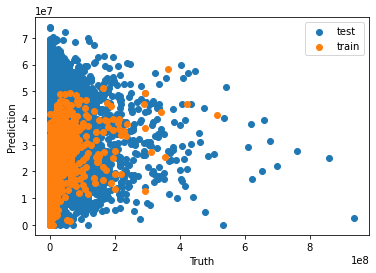

In [18]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(test_data_out, test_predictions, label='test')
plt.scatter(train_data_out, train_predictions, label='train')
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()